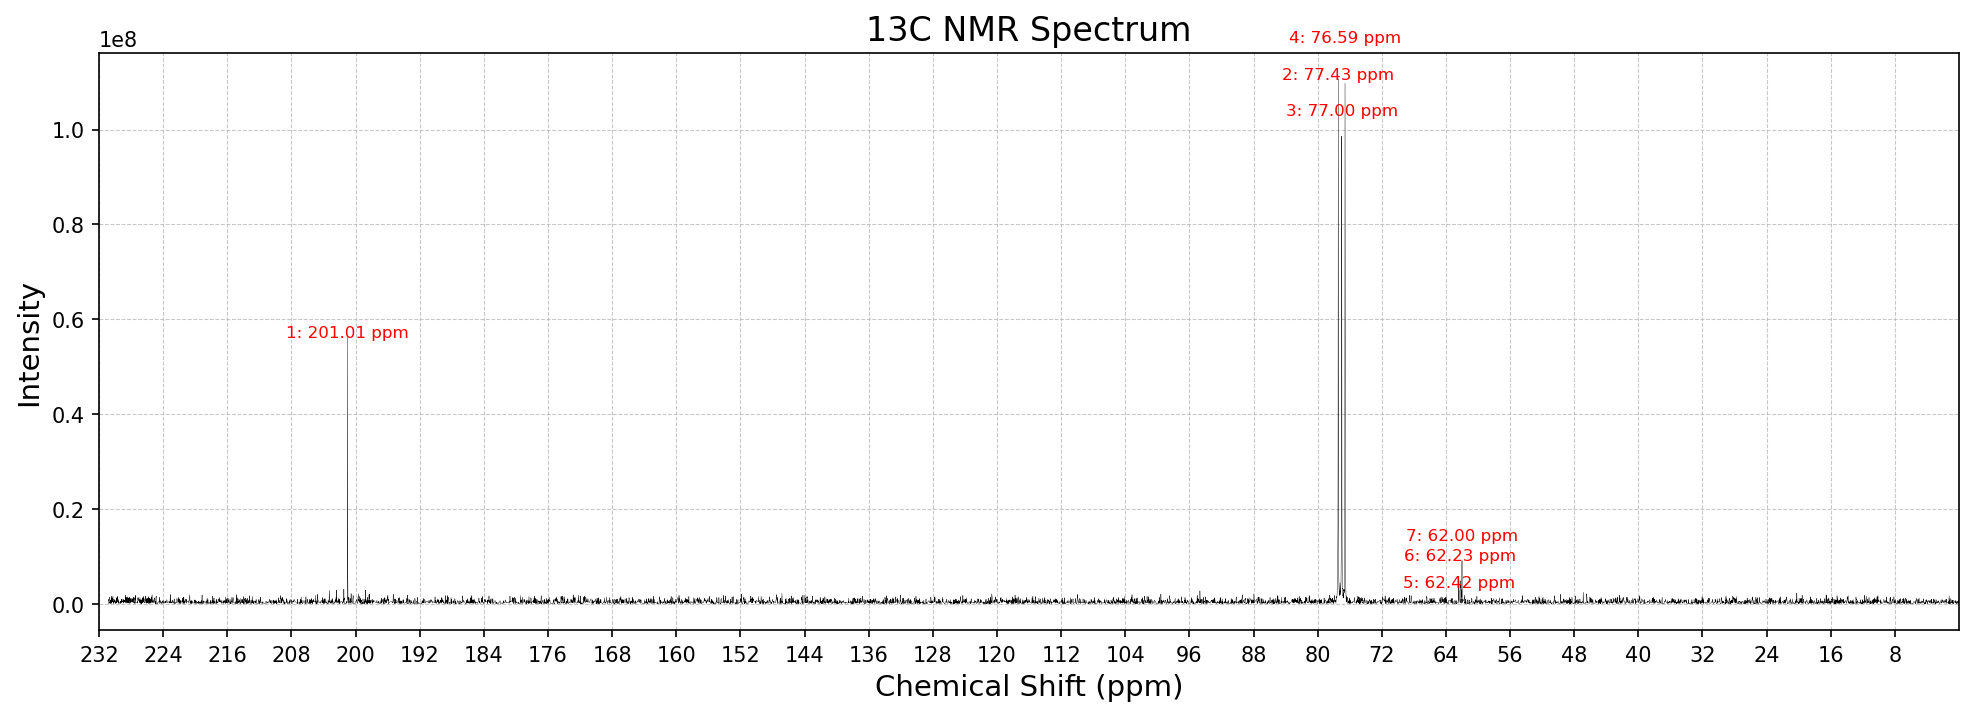

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.signal import find_peaks

# Define the file path
file_path = os.path.join('data', '13C_NMR.020.001.1r.txt')

# Function to extract metadata from the file
def extract_metadata(file_path):
    metadata = {}
    with open(file_path, "r") as f:
        for line in f:
            # Only extract lines starting with keywords that contain metadata info
            if "=" in line:
                # Split by "=" to separate key and value
                key, value = line.split("=", 1)
                key = key.strip()  # Strip any leading/trailing spaces
                value = value.strip()  # Strip spaces from the value
                
                # Try converting values to float if possible
                try:
                    value = float(value)
                except ValueError:
                    pass  # Keep as string if it can't be converted

                metadata[key] = value

    return metadata

# Check if the file exists
if os.path.exists(file_path):
    try:
        # Extract metadata
        metadata = extract_metadata(file_path)

        # Open the file and filter out invalid lines
        numeric_lines = []
        with open(file_path, "r") as f:
            for line in f:
                # Split line into parts
                parts = line.split()
                # Ensure exactly two numerical values per line
                if len(parts) == 2:
                    try:
                        # Append only valid data (exclude negative intensities)
                        ppm_value = float(parts[0])
                        intensity_value = float(parts[1])
                        numeric_lines.append([ppm_value, intensity_value])
                    except ValueError:
                        continue  # Skip lines that can't be converted

        # Convert to NumPy array
        data = np.array(numeric_lines)

        # Ensure data is not empty
        if data.shape[0] == 0:
            raise ValueError("No valid numerical data found in the file.")

        # Extract chemical shift (ppm) and intensity
        ppm = data[:, 0]  # First column (chemical shift)
        intensity = data[:, 1]  # Second column (intensity)

        # Set a higher intensity threshold to filter out very low values (e.g., below 5000)
        min_intensity = 5000
        
        # Apply the intensity filter to both ppm and intensity
        valid_indices = intensity >= min_intensity
        ppm = ppm[valid_indices]
        intensity = intensity[valid_indices]

        # Try a slightly lower prominence threshold to capture more peaks but avoid noise
        prominence = 3200000  # Slightly lowered to include more peaks
        distance = 2  # Distance between peaks in terms of data points
        peaks, properties = find_peaks(intensity, prominence=prominence, distance=distance)

        # Plot the NMR spectrum
        plt.figure(figsize=(16, 5), dpi=150)  # Increase DPI for higher resolution
        plt.plot(ppm, intensity, color='black', linewidth=0.2)  # Extremely thin line

        # Invert x-axis (standard for NMR)
        plt.gca().invert_xaxis()

        # Set x-axis limits (232 to 0 ppm) based on metadata
        if 'sweep_width' in metadata and 'offset' in metadata:
            plt.xlim(metadata["sweep_width"] + metadata["offset"], 0)
        else:
            plt.xlim(232, 0)  # Fallback if metadata is missing

        # Set x-axis ticks with interval of 8 ppm
        plt.xticks(np.arange(232, 0, -8))

        # Labels and title, adding metadata info
        plt.xlabel("Chemical Shift (ppm)", fontsize=14)
        plt.ylabel("Intensity", fontsize=14)

        # Adding the metadata information to the plot title
        title = f"13C NMR Spectrum"
        if 'solvent' in metadata:
            title += f" (Solvent: {metadata['solvent']})"
        if 'temperature' in metadata:
            title += f" (Temp: {metadata['temperature']}°C)"
        
        plt.title(title, fontsize=16)

        # Track previously plotted ppm values to avoid conflicts
        label_offsets = {}

        # Loop through each peak and plot it
        for i, peak in enumerate(peaks):
            current_ppm = ppm[peak]
            offset_y = 0  # Default vertical offset

            # Check if the current peak is too close to a previously placed peak
            for prev_ppm, prev_offset_y in label_offsets.items():
                if abs(current_ppm - prev_ppm) < 0.5:  # If the peaks are too close (within 0.5 ppm)
                    offset_y = prev_offset_y + 10  # Move the label further up (adjust vertical space)
                    break  # Break the loop to apply the new offset

            # After determining the offset, store the ppm and its corresponding y-offset
            label_offsets[current_ppm] = offset_y

            # Annotate with the adjusted ppm and intensity values (without modifying ppm)
            plt.annotate(f'{i+1}: {current_ppm:.2f} ppm', (current_ppm, intensity[peak]),
                         textcoords="offset points", xytext=(0, offset_y), ha='center', fontsize=8, color='red')

        # Add grid for better visualization
        plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

        # Show the plot
        plt.show()

    except Exception as e:
        print(f"Error processing file: {e}")
else:
    print(f"File not found: {file_path}")
